In [1]:
import pickle
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

In [359]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Todos
 - Feature creation 
  - [x] add polynomial features
  - [x] add gender feature
  - [x] add state feature
  - [ ] add census region and subregion
  - [ ] add interaction features
  - [x] one-hot encode race or include it in the regression
  - [ ] apply more transformations to the variables (log, etc.)
  - [ ] Do some dimensionality reduction / clustering to add features?
  - [ ] Run KNN on PCA'd features
 - Hyperparameter tuning
  - [x] Grid search for all classifiers and meta classfiers
  - [A User's Guide to SVMs](http://pyml.sourceforge.net/doc/howto.pdf)
 - Model stacking / Pipelining / Ensembling
  - [ ] Review Kaggle posts / [approaches to model stacking](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/) 
  - [ ] Review Kaggle posts / approaches to multi-model voting
 - Model Diagnostics
  - [ ] Update ROC curve
  - [ ] Run Classification reports for all classifiers
  - [ ] run logistic regression (or another classifier) to get class probabilities.  Identify the data points that are getting low probabilities
  - [x] create a pipeline for identifying the miss-classified datapoints and investigate the features that may be causing issues
  - [ ] See which classifiers do best on the hard cases  
  - [ ] See this [kaggle post](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Metrics to Evaluate Machine Learning Algorithms in Python](http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)
  - [Visulaizing Mistakes](https://www.kaggle.com/ngutten/otto-group-product-classification-challenge/visualizing-mistakes/code)
  - [Model evaluation, model, selection, and algo selection Pt. 1](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html)
  

In [492]:
df = pd.read_csv('../data/clean/surveys.csv')

In [493]:
with open('./bad_data.pickle', 'rb') as f:
    bdf = pickle.load(f)

In [494]:
with open('./transative_df.pickle', 'rb') as f:
    tdf = pickle.load(f)

In [495]:
# df[df.income == 'Prefer not to answer']

In [496]:
# Question: how to impute missing data
svo = df.loc[~(df._id.isin(bdf._id)), :]
svo.loc[:, 'income'] = svo.loc[:, 'income'].astype(int)
svo.loc[:, event_cols] = svo.loc[:, event_cols].fillna(0)
svo.reset_index(drop=True, inplace=True)

In [497]:
svo = pd.merge(svo, tdf, how='left', left_on='_id', right_on='session')

In [500]:
# svo[svo.case=='hard'][['transitive', 'case']]

In [501]:
# sns.distplot(df[df.svo.notnull()].svo)
# sns.distplot(svo.svo)

In [502]:
# sns.distplot(svo[svo.case!='hard'].svo)
# sns.distplot(df[df.svo.notnull()].svo)

### Features

In [503]:
demo_cols = [
    'age', 'income', 'female', 'other_gender',
    'education', 'politics', 'ethnicity_other',
    'religiosity', 'trust_development',
    'dependence_development',
    'relationship_development'
]

In [504]:
interest_cols = [
    'health_fitness', 'indoor',
    'life_style', 'nature', 'outdoor',
    'performance_arts', 'sports', 'other'
]

In [505]:
event_cols = [
    'ev0', 'ev1', 'ev2',
    'ev3', 'ev4', 'ev5',
    'i0', 'i1', 'i2', 'i4'
]

In [506]:
interaction_cols = [
    'rel_pol'
]

In [507]:
# state_cols = [
#     'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
#     'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
#     'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
#     'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
#     'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
#     'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
#     'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
#     'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Utah',
#     'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'
#]
region_cols = [
    'region_midwest', 'region_northeast', 
    'region_south', 'region_west',
]
division_cols = [
    'region_division_east_north_central',
    'region_division_east_south_central', 'region_division_mid_atlantic',
    'region_division_mountain', 'region_division_new_england',
    'region_division_pacific', 'region_division_south_atlantic',
    'region_division_west_north_central',
    'region_division_west_south_central'    
]
# state_cols = ['state', 'region', 'region_division']

In [508]:
meta_cols = [
    'durationSeconds'
]

In [509]:
demo_preds = interest_cols + demo_cols + interaction_cols
full_preds = interest_cols + demo_cols + interaction_cols + meta_cols + event_cols
with_state_preds = interest_cols + demo_cols + interaction_cols + meta_cols + event_cols + region_cols

In [510]:
target_cols = with_state_preds

In [511]:
# sdf = svo[svo.case!='hard'].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
# tdf = svo[svo.case!='hard'].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
sdf = svo[svo.transitive].loc[:, ['svo'] + target_cols].dropna(axis=1, how='all')
tdf = svo[svo.transitive].loc[:, ['type'] + target_cols].dropna(axis=1, how='all')
psdf = svo[svo.transitive].loc[:, ['prosocial'] + target_cols].dropna(axis=1, how='all')

In [512]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [519]:
X = tdf.ix[:, 1:].reset_index(drop=True)
# X = sdf.ix[:, 1:]
# X = psdf.ix[:, 1:]

In [514]:
# X_scaled = minmax_scale(X)

In [515]:
y_svo = sdf.svo.as_matrix()
y_type = pd.factorize(tdf.type.as_matrix())[0]
y_ps = psdf.prosocial

In [349]:
# Undersampler
us = RandomUnderSampler(ratio=.6)

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ps, test_size=.25)

In [315]:
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [316]:
# y_train_res[y_train_res == 1].shape

In [317]:
# y_train[y_train == 1].shape

In [318]:
# X_train_res[X_train_res == 1].shape

In [319]:
# X_train[X_train == 0].shape

### Feature Engineering

In [33]:
poly = PolynomialFeatures(2)

In [52]:
EX = poly.fit_transform(X)

In [53]:
### Add interaction terms

In [489]:
# Feature Selection through Variance Threshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = sel.fit_transform(X)

In [491]:
las = Lasso().fit(X, y_svo)
model = SelectFromModel(las, prefit=True)

In [492]:
X_new = model.transform(X)

In [186]:
# Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, LassoLars

# Hyper parameter optimization
from sklearn.model_selection import GridSearchCV

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

## Regression

#### Scikits

In [38]:
estimator = LinearRegression()

In [40]:
# estimator.fit(X, y_svo)
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='neg_mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -151.53


#### Statsmodels

In [320]:
fit1 = sm.OLS(y_svo, X)

In [321]:
fit1_res = fit1.fit()

In [322]:
summary = fit1_res.summary()

In [323]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     83.47
Date:                Sat, 29 Apr 2017   Prob (F-statistic):          5.57e-195
Time:                        23:44:44   Log-Likelihood:                -2326.3
No. Observations:                 593   AIC:                             4721.
Df Residuals:                     559   BIC:                             4870.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
health_fitness               0.4476      1.176      0.381      0.704      -1.862       2.757
indoor                       1.8569      1.225      1.516      0.130      -0.549       4.263
life_style                  -0.6408      1.217     -0.527      0.599      -3.031       1.750
nature                       3.0638      1.225      2.501      0.013       0.658       5.470
outdoor                     -1.7570      1.239     -1.418      0.157      -4.190       0.676
performance_arts             0.2043      1.157      0.177      0.860      -2.069       2.478
sports                      -0.0583      1.194     -0.049      0.961      -2.403       2.286
other                        0.3517      1.326      0.265      0.791      -2.253       2.956
age                          0.1291      0.038      3.357      0.001       0.054       0.205
income                       0.1594      0.179      0.892      0.373      -0.192       0.510
female                       1.2206      1.223      0.998      0.319      -1.181       3.622
other_gender                -1.3444      9.095     -0.148      0.883     -19.210      16.521
education                    0.3482      0.409      0.852      0.395      -0.455       1.151
politics                    -1.4173      0.671     -2.113      0.035      -2.735      -0.100
ethnicity_other              0.3517      1.326      0.265      0.791      -2.253       2.956
religiosity                  0.2045      0.420      0.487      0.626      -0.620       1.029
trust_development            0.4354      0.588      0.740      0.460      -0.720       1.591
dependence_development       0.7801      0.536      1.456      0.146      -0.272       1.832
relationship_development     1.2549      0.539      2.327      0.020       0.196       2.314
rel_pol                      0.2753      0.291      0.947      0.344      -0.296       0.847
durationSeconds              0.0498      0.014      3.435      0.001       0.021       0.078
ev0                         -0.0095      0.004     -2.553      0.011      -0.017      -0.002
ev1                          0.0137      0.003      4.919      0.000       0.008       0.019
ev2                         -0.0056      0.004     -1.241      0.215      -0.014       0.003
ev3                          0.0123      0.005      2.448      0.015       0.002       0.022
ev4                         -0.0703      0.008     -8.618      0.000      -0.086      -0.054
ev5                          0.0233      0.007      3.570      0.000       0.010       0.036
i0                          -0.9672      0.694     -1.394      0.164      -2.330       0.396
i1                          -1.7778      1.016     -1.749      0.081      -3.774       0.219
i2                          -3.6063      1.968     -1.832      0.067      -7.472       0.259
i4            

In [128]:
def reg_pred_actual(y_svo, y_pred):
    plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    plt.xlim([-25, 80])
    plt.ylim([-25, 80])
    sns.regplot(x=y_svo, y=y_pred)
    plt.title("Actual vs Predicted SVO score")
    plt.xlabel("Actual SVO")
    plt.ylabel("Predicted SVO")
    plt.plot([-25, 80], [-25, 80],'--', color='gray', linewidth=1)
    plt.axhline(-12.04, color='gray', linewidth=.5)
    plt.axhline(22.45, color='gray', linewidth=.5)
    plt.axhline(57.15, color='gray', linewidth=.5)
    plt.axvline(-12.04, color='gray', linewidth=.5)
    plt.axvline(22.45, color='gray', linewidth=.5)
    plt.axvline(57.15, color='gray', linewidth=.5)

In [129]:
y_fit1_pred = fit1_res.predict(X)

In [130]:
fit1_residuals = y_svo - y_fit1_pred

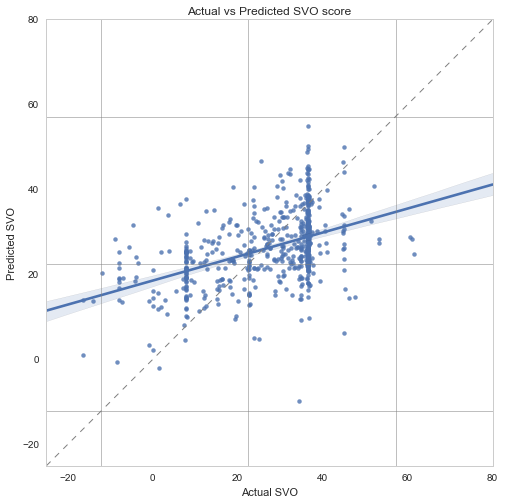

In [133]:
reg_pred_actual(y_svo, y_fit1_pred)

In [248]:
fit1_labels = pd.Series(y_fit1_pred).apply(angle2cat)

In [249]:
accuracy_score(y_type, fit1_labels)

0.76013513513513509

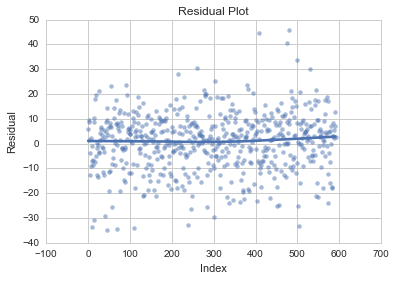

In [250]:
x = list(range(0, len(y_fit1_pred)))
index_residual_plot(x, fit1_residuals, fit_reg=True)


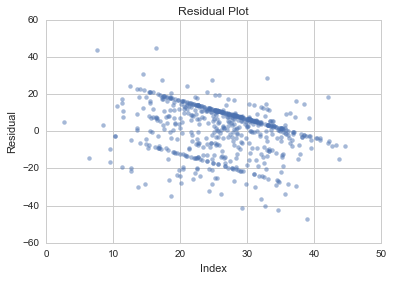

In [1125]:
index_residual_plot(y_fit1_pred, fit1_residuals)

In [1129]:
# ax = plt.axes()
# sm.graphics.influence_plot(fit1_res, ax=ax, criterion="cooks", figsize=(8,6))

### Random Forest Regressor

In [252]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)

In [115]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 15],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False]}

In [116]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg_grid = GridSearchCV(rf_reg, param_grid=param_grid)

In [225]:
rf_reg_grid.fit(X_train_res, y_train_res)

NameError: name 'rf_reg_grid' is not defined

In [140]:
rf_reg_grid.best_score_

0.024798734072853806

In [253]:
estimator.fit(X_train_res, y_train_res)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [254]:
score = cross_val_score(estimator, X, y_svo, cv=10, scoring='mean_squared_error').mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -97.14


In [255]:
y_pred = estimator.predict(X)

In [256]:
r2_score(y_svo, y_pred)

0.9231726553374171

In [257]:
mean_squared_error(y_svo, y_pred)

13.973677949928327

In [258]:
rf_labels = pd.Series(y_pred).apply(angle2cat)

In [259]:
# rf_labels

In [260]:
accuracy_score(y_type, rf_labels)

0.94932432432432434

In [262]:
yt = y_pred + (.085 * (y_pred - y_pred.mean()))**3

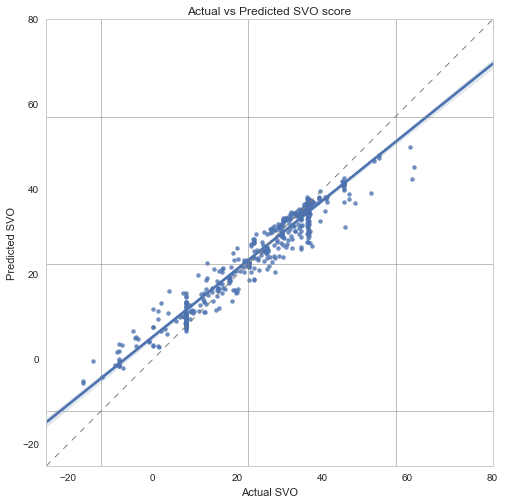

In [263]:
reg_pred_actual(y_svo, y_pred)

In [264]:
estimator.feature_importances_

array([  5.79516582e-03,   2.09166868e-03,   4.99333195e-03,
         4.41856951e-03,   2.82116691e-03,   5.72733747e-03,
         5.72545043e-03,   7.91929499e-04,   2.90381354e-02,
         2.06399259e-02,   5.32365884e-03,   4.86096812e-04,
         1.35730693e-02,   1.45950138e-02,   1.76066381e-02,
         2.12925717e-02,   1.17857323e-02,   1.15018157e-02,
         1.31311321e-02,   8.19379719e-02,   7.95623558e-02,
         1.11765865e-01,   4.29244872e-02,   4.73258114e-02,
         3.64501282e-01,   6.49331279e-02,   6.33189840e-03,
         3.14525718e-03,   6.11041394e-03,   1.23119902e-04])

In [265]:
rf_residuals = y_svo - yt

In [98]:
def index_residual_plot(index, residual, fit_reg=False):
    df = pd.DataFrame({'Index': index, 'Residual': residual})
    sns.regplot(x='Index', y='Residual', 
                data=df, lowess=True, fit_reg=fit_reg,
                scatter_kws={'alpha':0.5})
    plt.title("Residual Plot")

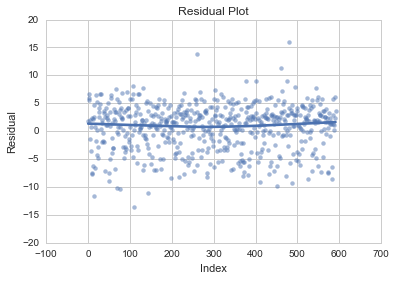

In [1142]:
index_residual_plot(x, rf_residuals, fit_reg=True)

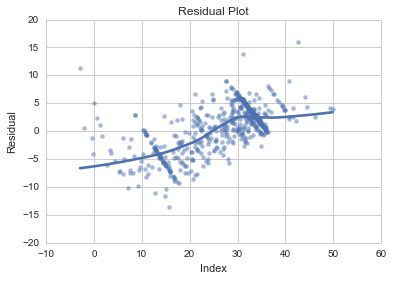

In [1143]:
index_residual_plot(y_pred, rf_residuals, fit_reg=True)

In [1144]:
imp = pd.Series(estimator.feature_importances_)

### Gradient Boosting Regressor

In [173]:
gb_reg = GradientBoostingRegressor(n_estimators=100)

In [174]:
gb_reg.fit(X, y_svo)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [175]:
y_gb_pred = gb_reg.predict(X)

In [176]:
r2_score(y_svo, y_gb_pred)

0.4530684977840499

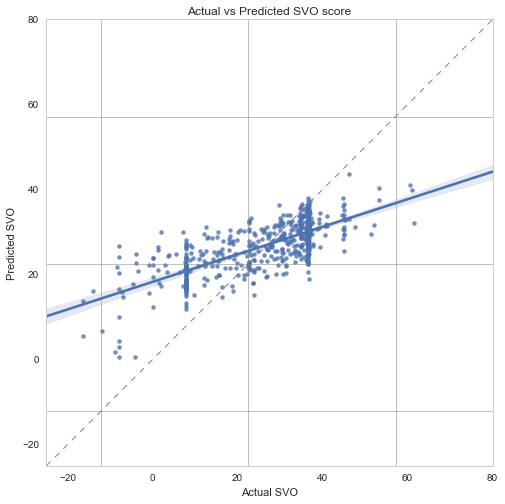

In [177]:
reg_pred_actual(y_svo, y_gb_pred)

In [178]:
gb_residuals = y_svo - y_gb_pred

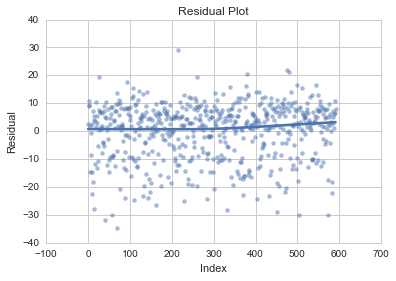

In [179]:
index_residual_plot(x, gb_residuals, fit_reg=True)

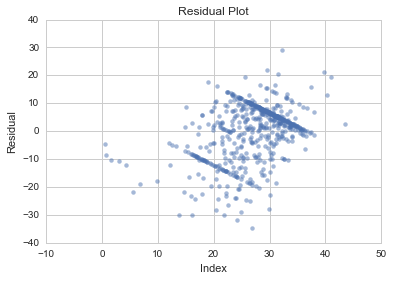

In [1153]:
index_residual_plot(y_gb_pred, gb_residuals)

### Support Vector Regressor

In [1155]:
svr_reg = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1156]:
svr_reg.fit(X, y_svo)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1157]:
y_svr_pred = svr_reg.predict(X)

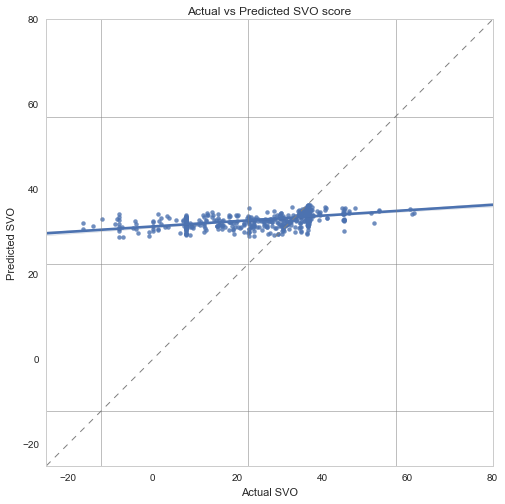

In [1158]:
reg_pred_actual(y_svo, y_svr_pred)

In [1159]:
svr_residuals = y_svo - y_svr_pred

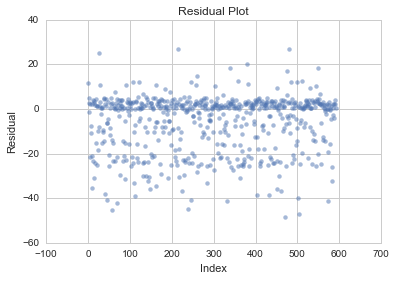

In [1160]:
index_residual_plot(x, svr_residuals)

In [1161]:
svo.type.unique()

array(['prosocial', 'individualistic', 'altruistic', 'competitive'], dtype=object)

In [1162]:
pd.factorize(tdf.type.as_matrix())[1]

array(['prosocial', 'individualistic', 'altruistic', 'competitive'], dtype=object)

In [296]:
def angle2cat(SVO_angles):
    if SVO_angles >= 57.15:
        return 2 #"altruistic"
    elif SVO_angles < 57.15 and SVO_angles >= 22.45:
        return 0 #"prosocial"
    elif SVO_angles < 22.45 and SVO_angles >= -12.04:
        return 1 #"individualistic"
    elif SVO_angles < -12.04:
        return 3 #"competitive"

In [91]:
labels = pd.Series(y_pred).apply(angle2cat)
accuracy_score(y_type, labels)

### KNN Regressor

In [267]:
knn_reg = KNeighborsRegressor()

In [268]:
knn_reg.fit(X, y_svo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [269]:
y_knn_pred = knn_reg.predict(X)

In [270]:
r2_score(y_svo, y_knn_pred)

0.53186431187796779

In [271]:
labels = pd.Series(y_knn_pred).apply(angle2cat)
accuracy_score(y_type, labels)

0.83614864864864868

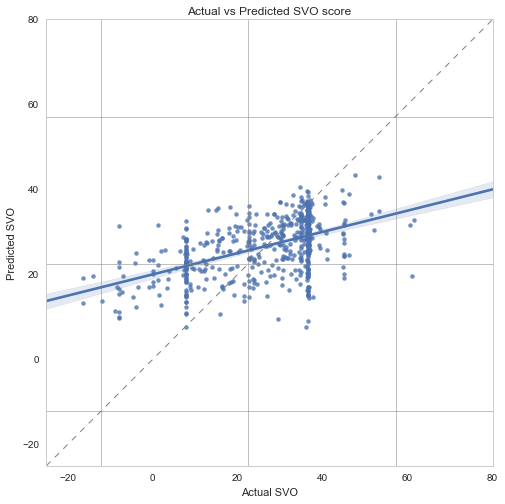

In [181]:
reg_pred_actual(y_svo, y_knn_pred)

# Classification

### Logistic Regression

In [174]:
lr_clf = LogisticRegression()

In [212]:
lr_clf.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [214]:
y_lr_preds = lr_clf.predict(X_test)

In [179]:
cr = classification_report(y_lr_preds, y_test)
print(cr)

             precision    recall  f1-score   support

        0.0       0.19      0.50      0.27        16
        1.0       0.92      0.74      0.82       133

avg / total       0.85      0.71      0.76       149



In [215]:
cr = classification_report(y_lr_preds, y_test)
print(cr)

             precision    recall  f1-score   support

        0.0       0.65      0.65      0.65        43
        1.0       0.86      0.86      0.86       106

avg / total       0.80      0.80      0.80       149



### Bernoulli Naive Bayes

In [188]:
nb_clf = BernoulliNB()

In [216]:
nb_clf.fit(X_train_res, y_train_res)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [217]:
y_nb_preds = nb_clf.predict(X_test)

In [191]:
cr = classification_report(y_nb_preds, y_test)
print(cr)

             precision    recall  f1-score   support

        0.0       0.33      0.42      0.37        33
        1.0       0.82      0.75      0.78       116

avg / total       0.71      0.68      0.69       149



In [218]:
cr = classification_report(y_nb_preds, y_test)
print(cr)

             precision    recall  f1-score   support

        0.0       0.63      0.48      0.55        56
        1.0       0.73      0.83      0.77        93

avg / total       0.69      0.70      0.69       149



### Ensemble Classifiers

In [105]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 15],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [324]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                             n_estimators=300)

In [63]:
rf_grid = GridSearchCV(rf_clf, param_grid=param_grid)
gb_grid = GridSearchCV(rf_clf, param_grid=param_grid)

In [145]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 150, 300]
             }

In [146]:
ab_grid = GridSearchCV(ab_clf, param_grid=param_grid)

In [123]:
# rf_grid.fit(X_train, y_train)
# rf_grid.best_params_

In [125]:
# gb_grid.fit(X_train, y_train)
# gb_grid.best_params_

In [124]:
# ab_grid.fit(X_train, y_train)
# ab_grid.best_estimator_

In [127]:
score = cross_val_score(rf_clf, X, y_ps, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.84


In [329]:
rf_clf.fit(X_train_res, y_train_res)
gb_clf.fit(X_train_res, y_train_res)
ab_clf.fit(X_train_res, y_train_res);

In [326]:
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)
ab_clf.fit(X_train, y_train);

In [330]:
y_pred = rf_clf.predict(X_test)

In [331]:
cr = classification_report(y_test, y_pred, target_names=["prosocial", "proself"])
print(cr)

             precision    recall  f1-score   support

  prosocial       0.67      0.92      0.77        39
    proself       0.97      0.84      0.90       110

avg / total       0.89      0.86      0.87       149



In [132]:
# accuracy_score(y_test, y_pred)

In [133]:
imp = pd.Series(rf_clf.feature_importances_)

In [150]:
# feats = pd.DataFrame({'col': target_cols, 'imps': imp})

In [149]:
# feats.sort_values('imps', ascending=False).plot(
#     kind='bar', x=feats.sort_values('imps', ascending=False).col, figsize=(18,4))

### Support Vector Machine

In [226]:
svc_clf = SVC(C=10, kernel='linear', probability=True)

In [227]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [228]:
# svc_grid = GridSearchCV(svc_clf, param_grid)

In [229]:
svc_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [87]:
y_svc_pred = svc_clf.predict(X_test)

In [177]:
# score = cross_val_score(clf.best_estimator_, X, y_type, cv=10).mean()
# print("Score with the entire dataset = %.2f" % score)

### KNN

In [155]:
knn_clf = KNeighborsClassifier()

In [156]:
param_grid = [{
    'weights': ['uniform', 'distance'], 
    'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'metric': ['euclidean', 'cityblock']
}]

In [162]:
knn_grid = GridSearchCV(knn_clf, param_grid)

In [164]:
knn_grid.fit(X_train, y_train);

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'metric': ['euclidean', 'cityblock'], 'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [159]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [160]:
score = cross_val_score(knn_clf, X, y_type, cv=10).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.81


In [165]:
y_knn_pred = knn_grid.best_estimator_.predict(X_test)

In [166]:
accuracy_score(y_test, y_knn_pred)

0.77181208053691275

### Voting Classifier

In [555]:
vote_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_), 
        ('gb', gb_grid.best_estimator_), 
        ('knn', knn_grid.best_estimator_)
    ], voting='soft', weights=[2, 5, 1])

In [556]:
score = cross_val_score(vote_clf, X, y_type, cv=3).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 0.82


### Autolearning Classifier

In [470]:
# import autosklearn.classification

### Diagnostics and Model Checking

In [59]:
## See how the model performs with more data

In [61]:
# classification_report(y_test, y_pred, target_names=f[1])
# confusion_matrix(y_test, y_pred)

In [122]:
adf = pd.DataFrame({'train': y_test, 'test': y_pred})

In [125]:
adf['loss'] = adf.apply(lambda r: 1 if r['test'] == r['train'] else 0, axis=1)

In [138]:
f = pd.factorize(tdf.type.as_matrix())

In [150]:
# adf.replace({
#     0: 'individualistic',
#     1: 'prosocial',
#     2: 'altruistic',
#     3: 'competitive'
# })

### Learning Curve

In [170]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

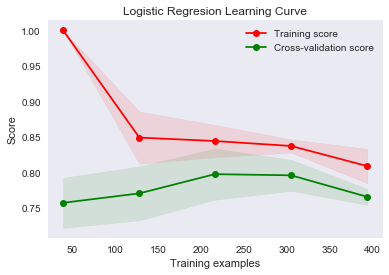

In [219]:
plot_learning_curve(lr_clf, "Logistic Regresion Learning Curve", X, y_ps)

<module 'matplotlib.pyplot' from '/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

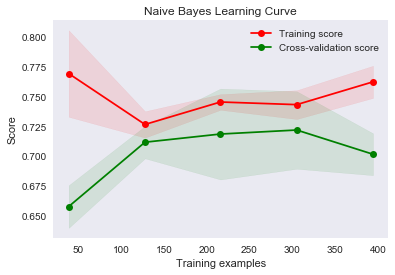

In [220]:
plot_learning_curve(nb_clf, "Naive Bayes Learning Curve", X, y_ps)

<module 'matplotlib.pyplot' from '/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

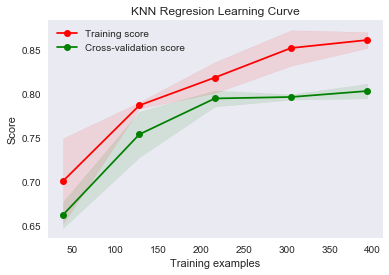

In [209]:
plot_learning_curve(knn_clf, "KNN Regresion Learning Curve", X, y_ps)

<module 'matplotlib.pyplot' from '/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

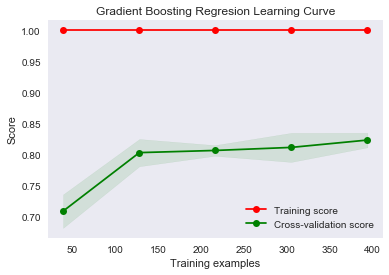

In [210]:
plot_learning_curve(gb_clf, "Gradient Boosting Regresion Learning Curve", X, y_ps)

<module 'matplotlib.pyplot' from '/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

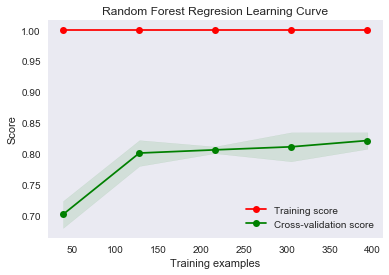

In [211]:
plot_learning_curve(gb_clf, "Random Forest Regresion Learning Curve", X, y_ps)

In [332]:
# plot_learning_curve(svc_clf, "SVC Learning Curve", X, y_ps)

### ROC curve

In [683]:
# Undersampler
# us = RandomUnderSampler(ratio=.5)
us = RepeatedEditedNearestNeighbours(size_ngh=2)

In [684]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ps, test_size=.25)

In [685]:
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [686]:
rf_clf.fit(X_train_res, y_train_res)
gb_clf.fit(X_train_res, y_train_res)
ab_clf.fit(X_train_res, y_train_res)
lr_clf.fit(X_train_res, y_train_res)
nb_clf.fit(X_train_res, y_train_res)
knn_clf.fit(X_train_res, y_train_res);

In [687]:
# rf_clf.fit(X_train, y_train)
# gb_clf.fit(X_train, y_train)
# ab_clf.fit(X_train, y_train)
# lr_clf.fit(X_train, y_train)
# nb_clf.fit(X_train, y_train)
# knn_clf.fit(X_train, y_train);

In [688]:
probs = gb_clf.predict_proba(X_test)
preds = probs[:,1]

In [689]:
probs2 = lr_clf.predict_proba(X_test)
preds2 = probs2[:,1]

In [690]:
probs3 = knn_clf.predict_proba(X_test)
preds3 = probs3[:,1]

In [691]:
probs4 = rf_clf.predict_proba(X_test)
preds4 = probs4[:,1]

In [692]:
probs5 = nb_clf.predict_proba(X_test)
preds5 = probs5[:,1]

In [693]:
# probs6 = svc_clf.predict_proba(X_test)
# preds6 = probs6[:,1]

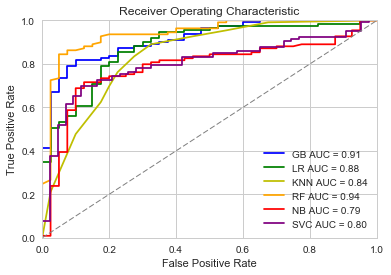

In [694]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, threshold = roc_curve(y_test, preds2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, threshold = roc_curve(y_test, preds3)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, threshold = roc_curve(y_test, preds4)
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, threshold = roc_curve(y_test, preds5)
roc_auc5 = auc(fpr5, tpr5)

# fpr6, tpr6, threshold = roc_curve(y_test, preds6)
# roc_auc6 = auc(fpr6, tpr6)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'GB AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'LR AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'y', label = 'KNN AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'orange', label = 'RF AUC = %0.2f' % roc_auc4)
plt.plot(fpr5, tpr5, 'red', label = 'NB AUC = %0.2f' % roc_auc5)
plt.plot(fpr6, tpr6, 'purple', label = 'SVC AUC = %0.2f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='gray', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
#plt.savefig("../img/roc.png")

In [695]:
# probs = pd.Series(preds).apply(np.max)
# adf['prob'] = probs
# adf[adf.loss==0]

### Identifying misclassified points

In [449]:
# Classifiers
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [450]:
clf = rf_clf

In [550]:
min_count = 0
runs = []
rdf = None
## train a classifier on anew training and testing set
while min_count <= 30:
    # Create placeholder vector
    run = np.full((1,X.shape[0],), np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y_ps, test_size=.25)
    # test on the entire data set
    clf.fit(X_train, y_train)
    # make predictions with the classifier
    y_pred = clf.predict(X_test)
    # check if they're correct or incorrect
    misclassified = ~np.equal(y_pred, y_test)
    min_count += 1
    # for each data point in the test set, if it's misclassified set the it's it's datapoint 
    # misclassified
    for dix, vix in enumerate(X_test.index):
        run[0][vix] = 1 if misclassified.iloc[dix] else 0
    runs.append(run[0])
    rdf = pd.DataFrame(runs)
    min_count = np.min(rdf.count())

In [551]:
hard_cases = rdf.mean()[rdf.mean() > .75].index
easy_cases = rdf.mean()[rdf.mean() == 0].index

In [552]:
svo.loc[hard_cases, 'case'] = 'hard'
svo.loc[easy_cases, 'case'] = 'easy'

In [567]:
# Style settings
sns.set_style('whitegrid')

def remove_gridlines(ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
def modify_gridlines(ax):
    for line in ax.get_ygridlines():
        line.set_linestyle(':')

    for line in ax.get_xgridlines():
        line.set_linestyle(':')

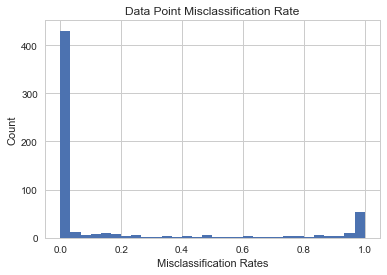

In [568]:
# Distribution of incorrect classifications
rdf.mean().hist(bins=30)
plt.title("Data Point Misclassification Rate")
plt.xlabel("Misclassification Rates")
plt.ylabel("Count")
plt.savefig("../img/misclassification_rate.png")

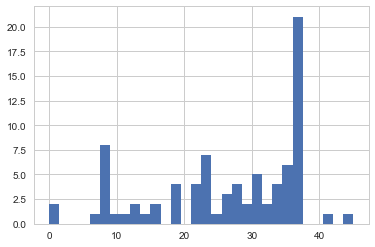

In [569]:
hard = svo.ix[hard_cases].svo.hist(bins=30)

In [570]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [711]:
cdf = svo.loc[:, ['case'] + target_cols]

In [736]:
X_clust = cdf.ix[cdf.case.notnull(), 1:]
y_clust = cdf.ix[cdf.case.notnull(), 'case']

In [737]:
X_clust, y_clust = us.fit_sample(X_clust, y_clust)

In [738]:
X_clust_scaled = min_max_scaler.fit_transform(X_clust)

In [739]:
mds = MDS(2, max_iter=100, n_init=1)
tsne = TSNE(n_components=2, perplexity=50)
pca = PCA(n_components=2)

In [740]:
clust = pca
X_mds = clust.fit_transform(X_clust_scaled)

In [741]:
mdf = pd.DataFrame({
    'x': X_mds.transpose()[0], 
    'y': X_mds.transpose()[1], 
    'case': y_clust #cdf[cdf.case.notnull()].case
})

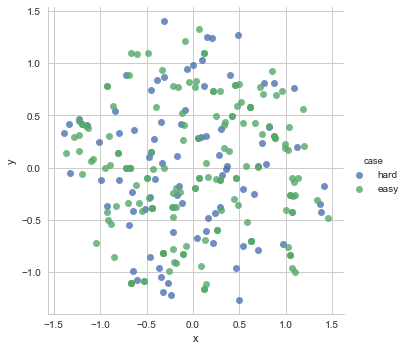

In [742]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='x', y='y', hue='case',
           fit_reg=False, data=mdf, scatter_kws={'alpha':0.8})

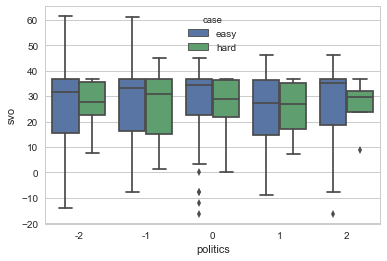

In [790]:
sns.boxplot(x='politics', y='svo', data=svo, hue='case')

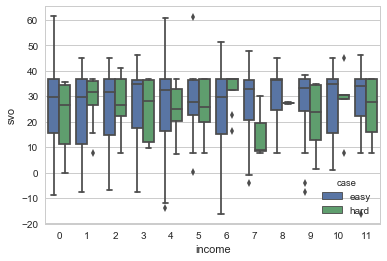

In [795]:
sns.boxplot(x='income', y='svo', data=svo, hue='case')

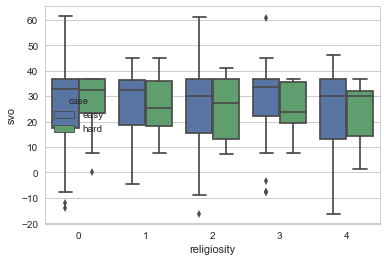

In [796]:
sns.boxplot(x='religiosity', y='svo', data=svo, hue='case')

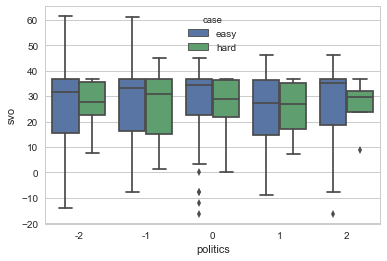

In [797]:
sns.boxplot(x='politics', y='svo', data=svo, hue='case')

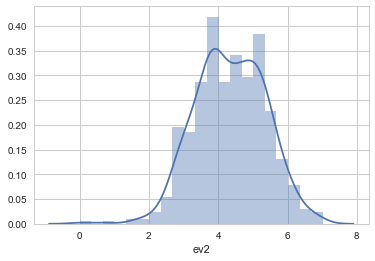

In [808]:
sns.distplot(np.log(svo[svo.ev2 > 0].ev2))

In [809]:
# sns.distplot(np.log(svo[svo.case=='easy'].ev4))
# sns.distplot(np.log(svo[svo.case=='hard'].ev4))

In [592]:
### Check if the hard cases are in the bad values
# hdf = svo.loc[svo.case=='hard', :]

### Classifying Hard Cases

In [770]:
gb_hard_clf = GradientBoostingClassifier(n_estimators=300)
rf_hard_clf = RandomForestClassifier(n_estimators=300)
svc_hard_clf = SVC(C=10, kernel='linear', probability=False)
knn_hard_clf = KNeighborsClassifier(n_neighbors=6)
lr_hard_clf = LogisticRegression()

In [771]:
# y_case = pd.factorize(svo.prosocial)[0]

In [772]:
# Undersampler
# us = RandomUnderSampler(ratio=.5)
us = RepeatedEditedNearestNeighbours(size_ngh=2)

In [773]:
hdf = svo[svo.case == 'hard']

In [774]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(hdf[target_cols], hdf.prosocial, test_size=.25)

In [775]:
X_train_res_c, y_train_res_c = us.fit_sample(X_train_c, y_train_c)

In [776]:
score = cross_val_score(gb_hard_clf, X_train_res_c, y_train_res_c, cv=3).mean()
print("Gradient Boosting Score = %.2f" % score)
score = cross_val_score(rf_hard_clf, X_train_res_c, y_train_res_c, cv=3).mean()
print("Random Forest Score = %.2f" % score)
score = cross_val_score(knn_hard_clf, X_train_res_c, y_train_res_c, cv=3).mean()
print("KNN Score = %.2f" % score)
score = cross_val_score(lr_hard_clf, X_train_res_c, y_train_res_c, cv=3).mean()
print("Logistic Regression Score = %.2f" % score)
score = cross_val_score(svc_hard_clf, X_train_res_c, y_train_res_c, cv=3).mean()
print("SVC Score = %.2f" % score)

Gradient Boosting Score = 0.79
Random Forest Score = 0.79
KNN Score = 0.84
Logistic Regression Score = 0.87
SVC Score = 0.76


In [783]:
lr_clf.fit(X_train_c, y_train_c)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [780]:
y_lr_hard_pred = lr_clf.predict(X_test_c)

In [784]:
y_lr_hard_pred_full = lr_clf.predict(X_test_c)

In [782]:
cr = classification_report(y_test_c, y_lr_hard_pred)
print(cr)

             precision    recall  f1-score   support

        0.0       0.40      0.67      0.50         6
        1.0       0.82      0.60      0.69        15

avg / total       0.70      0.62      0.64        21



In [785]:
cr = classification_report(y_test_c, y_lr_hard_pred_full)
print(cr)

             precision    recall  f1-score   support

        0.0       0.50      0.67      0.57         6
        1.0       0.85      0.73      0.79        15

avg / total       0.75      0.71      0.72        21



In [777]:
score = cross_val_score(gb_hard_clf, X_train_c, y_train_c, cv=3).mean()
print("Gradient Boosting Score = %.2f" % score)
score = cross_val_score(rf_hard_clf, X_train_c, y_train_c, cv=3).mean()
print("Random Forest Score = %.2f" % score)
score = cross_val_score(knn_hard_clf, X_train_c, y_train_c, cv=3).mean()
print("KNN Score = %.2f" % score)
score = cross_val_score(lr_hard_clf, X_train_c, y_train_c, cv=3).mean()
print("Logistic Regression Score = %.2f" % score)

Gradient Boosting Score = 0.71
Random Forest Score = 0.70
KNN Score = 0.65
Logistic Regression Score = 0.73


In [758]:
# case_pred = svc_hard_clf.predict(X_test_c)

In [759]:
# confusion_matrix(case_pred, y_test_c)

In [ ]:
# score = cross_val_score(gb_hard_clf, svo[target_cols], y_case, cv=3).mean()
# print("Score with the entire dataset = %.2f" % score)

In [ ]:
# np.argmax(gb_hard_clf.feature_importances_)

target_cols[16]

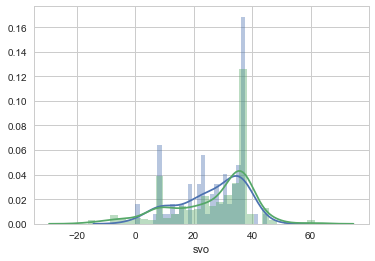

In [696]:
# sns.set(style="ticks", color_codes=True)
# g = sns.FacetGrid(svo[svo.notnull()], col="case")
# g = g.map(plt.hist, "svo", bins=30)
sns.distplot(svo[svo.case=='hard'].svo, bins=30)
sns.distplot(svo[svo.case=='easy'].svo, bins=30)

In [344]:
# sns.lmplot(x='ev4', y='svo', data=svo, hue='case')

In [302]:
# X = cluster_df.ix[:, 1:].as_matrix()
# X_scaled = min_max_scaler.fit_transform(X)

In [174]:
# np.in1d(y_pred, y_test)

In [564]:
rf_clf = RandomForestClassifier(n_estimators=300)
gb_clf = GradientBoostingClassifier(n_estimators=300)
svc_clf = SVC(C=10, kernel='linear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

### Reviewing classification probabilities